In [1]:
import pygplates
import numpy as np

def make_GPML_velocity_feature(Long,Lat):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 

    # Add points to a multipoint geometry
    multi_point = pygplates.MultiPointOnSphere([(float(lat),float(lon)) for lat, lon in zip(Lat,Long)])

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('myfilename.gpmlz')
    
    # for use within the notebook, the velocity domain feature is returned from the function
    return output_feature_collection


In [2]:
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)
Xg,Yg = np.meshgrid(Xnodes,Ynodes)
Xg = Xg.flatten()
Yg = Yg.flatten()

velocity_domain_features = make_GPML_velocity_feature(Xg,Yg)

In [5]:
import pygplates

rotation_filename = '../1-data/PALEOMAP_PlateModel.rot'

input_topology_filename = '../1-data/PlateBoundaries.gpml'

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

# Set the reconstruction time we want to compute the velocities
time = 0.

# Calculate velocities using a delta time interval of 5My.
delta_time = 5.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities(
                    [velocity_domain_point],
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0,0,0))

In [6]:
pt_vel_mag=[]
pt_vel_az=[]
for velocity_vector in all_velocities:
    pt_vel_mag.append(velocity_vector[0])
    pt_vel_az.append(velocity_vector[1])

pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])

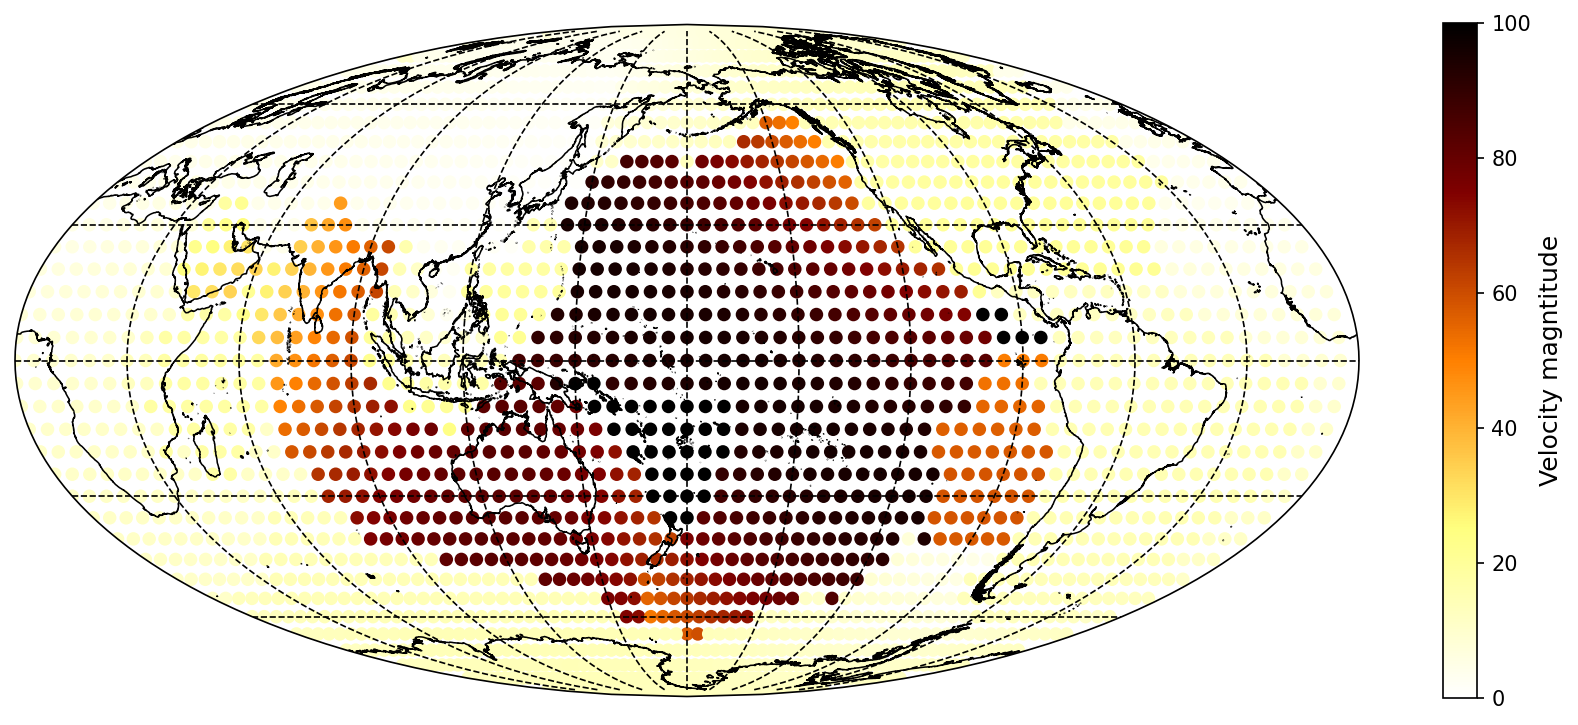

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

# Create figure window & map
fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0], projection = ccrs.Mollweide(central_longitude=180))
ax_map.coastlines(resolution='10m', color='black', linewidth=0.75)
ax_map.gridlines(color='black',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))

# Plot the lat-lon point pairs onto the map
x,y = pt_lon, pt_lat
im = ax_map.scatter(x,y,transform=ccrs.PlateCarree(),c=pt_vel_mag,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=100)

# add colorbar.
fig.colorbar(im, ax=ax_map,location='right',shrink=0.45).set_label('Velocity magntitude',fontsize=12)


ax_map.set_global()
plt.show()


In [ ]:
# For variety, calculate velocities using a delta time interval of 5My.
delta_time = 5.

time = 0.

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities(
                    [velocity_domain_point],
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0,0,0))

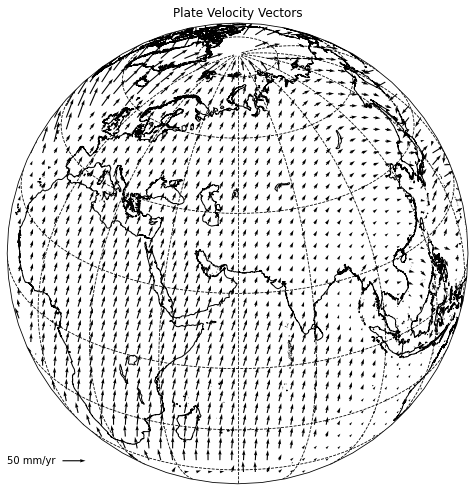

In [12]:
import cartopy.feature as cfeature

pt_vel_n=[]
pt_vel_e=[]

for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))


# create figure, add axes, and map
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8], projection = ccrs.Orthographic(central_longitude=60, central_latitude=30))

# draw coastlines, parallels, meridians, and lake features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.gridlines(color='black',linestyle='--', xlocs=np.arange(0,360,20), ylocs=np.arange(-80,90,20))
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')

# now plot.
Q = ax.quiver(Xnodes,Ynodes,u,v,scale=1000,transform = ccrs.PlateCarree(), regrid_shape=40)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')


# set plot title
ax.set_title('Plate Velocity Vectors')
plt.show()

In [10]:
def Get_Plate_Velocities(velocity_domain_features,topology_features,rotation_model,time,delta_time,rep):
    # Define a function 

    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

    for velocity_domain_feature in velocity_domain_features:

        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():

            for velocity_domain_point in velocity_domain_geometry.get_points():

                all_domain_points.append(velocity_domain_point)

                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                if partitioning_plate:

                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)
                    
                    if rep=='mag_azim':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                        all_velocities.append(velocities[0])

                    elif rep=='vector_comp':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                [velocity_domain_point],
                                velocity_vectors)
                        all_velocities.append(velocities[0])

                else:
                    all_velocities.append((0,0,0))

    return all_velocities

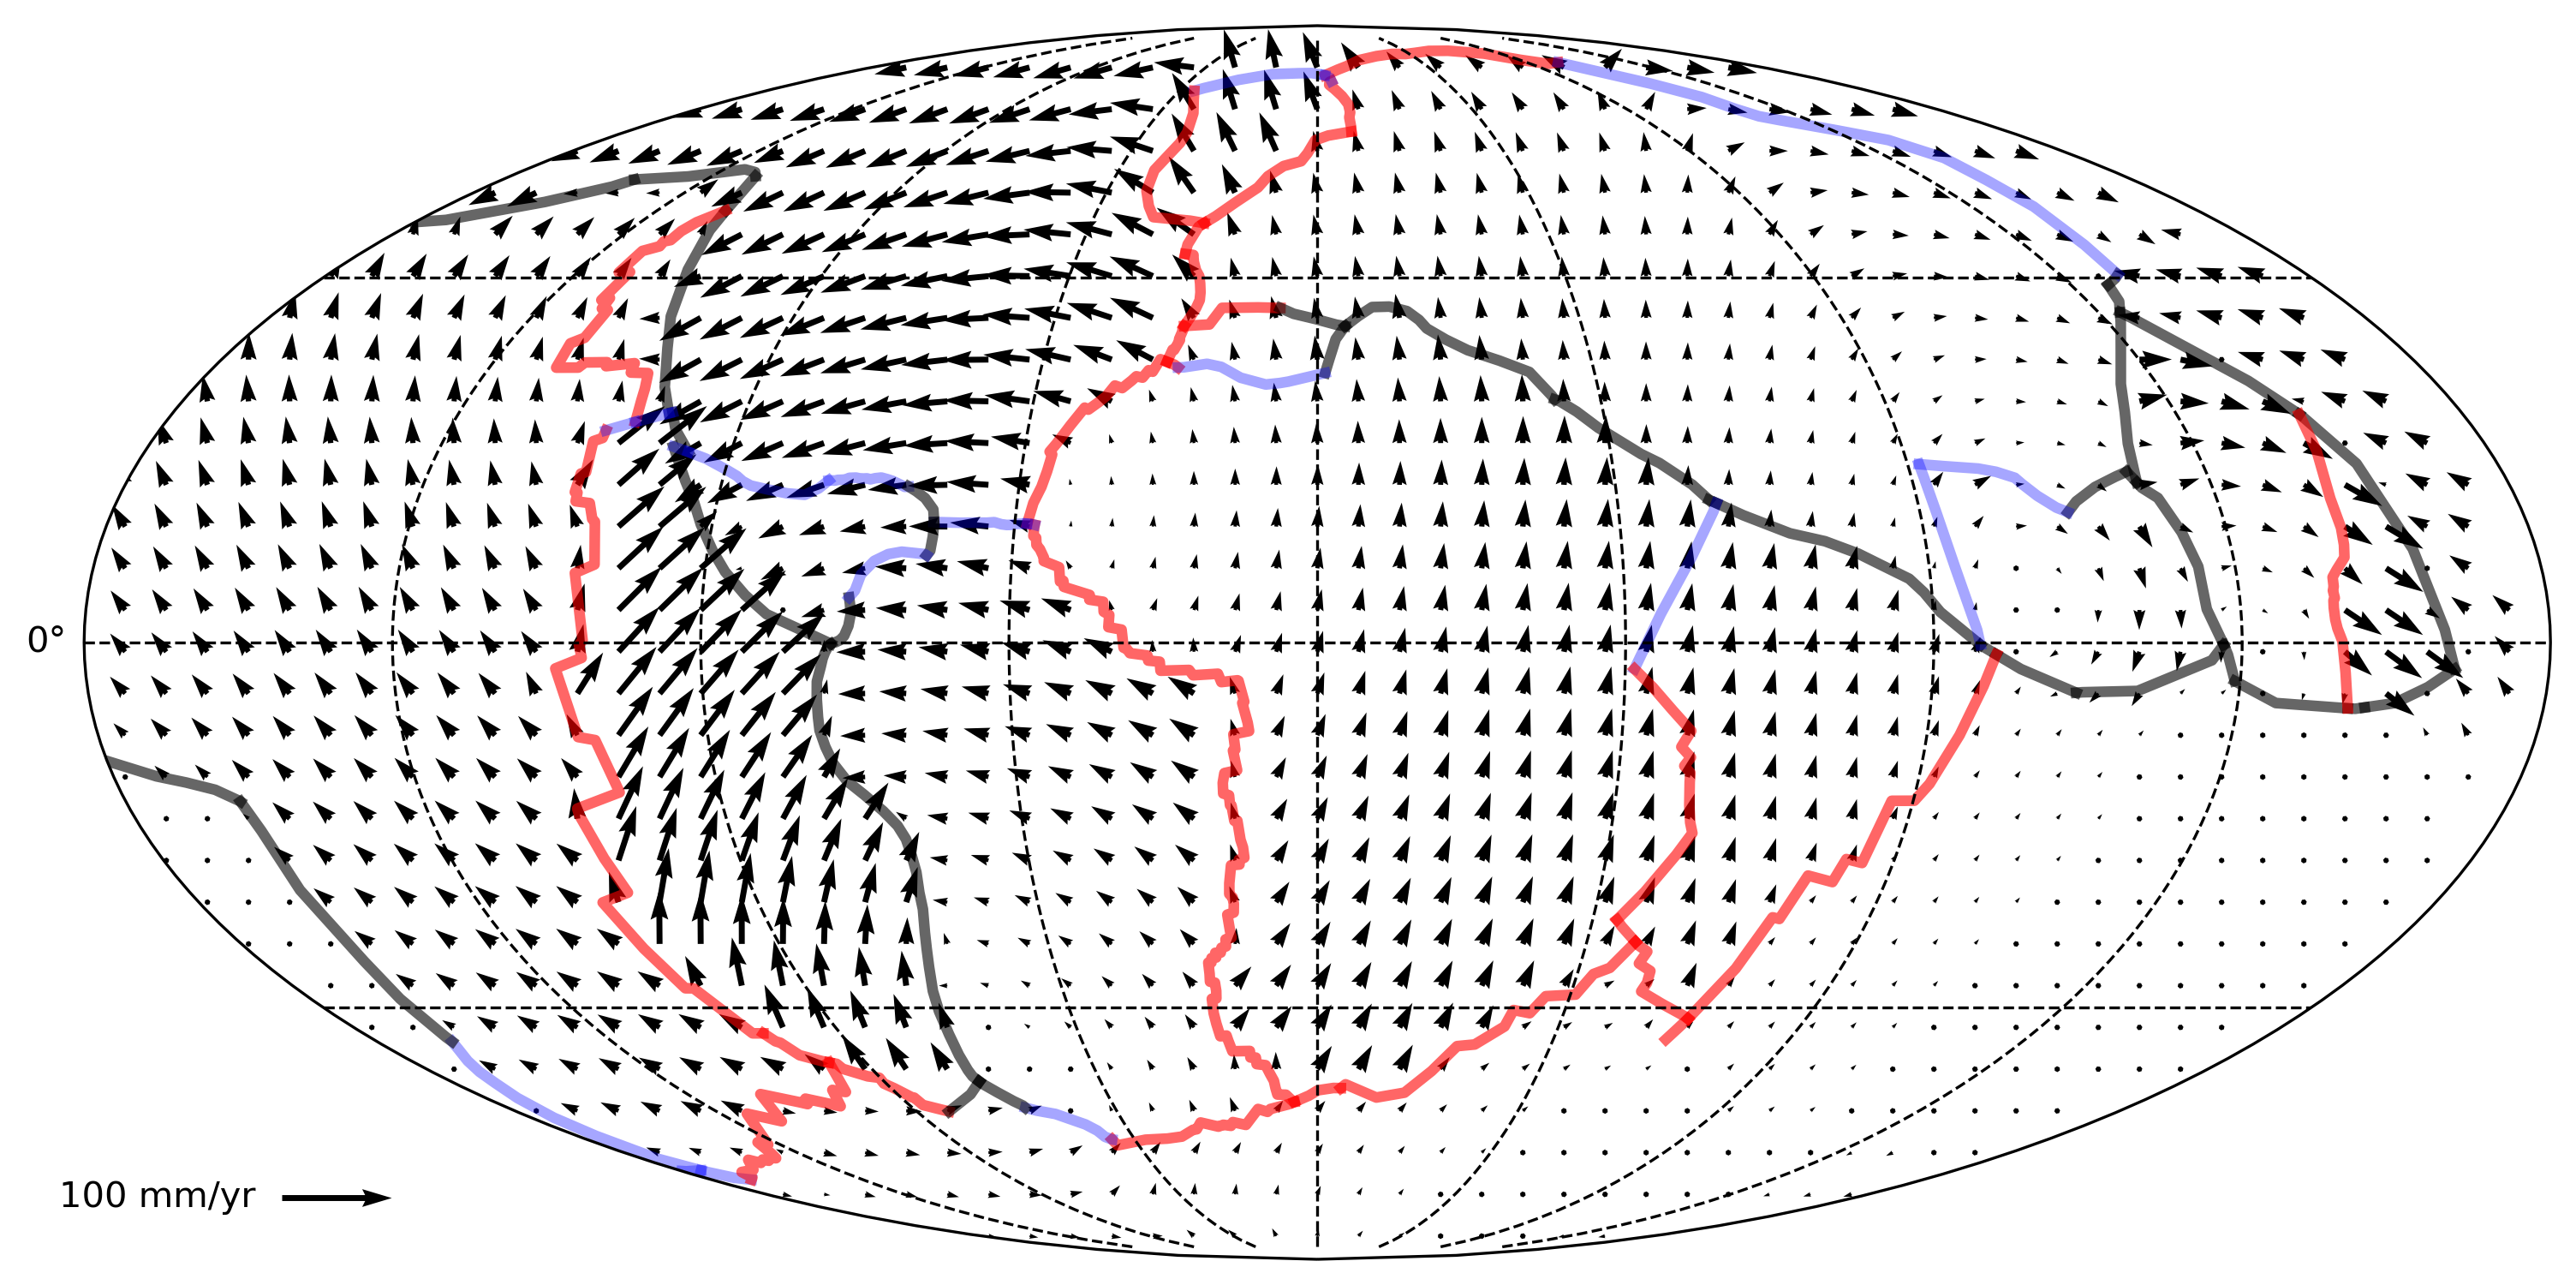

In [11]:
# Set time parameters
time = 50.
delta_time = 10.

# Call the function we created above to get the velocities
all_velocities = Get_Plate_Velocities(velocity_domain_features,
                                      topology_features,
                                      rotation_model,
                                      time,
                                      delta_time,
                                      'vector_comp')


# The rest of the cell is for plotting, including rendering resolved topological boundaries to the map
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

# create figure, add axes, and map
fig = plt.figure(figsize=(12,8), dpi=300)
pmap = fig.add_axes([0.1,0.1,0.8,0.8], projection = ccrs.Mollweide(central_longitude=0))

# draw gridlines
gl = pmap.gridlines(color='black',linestyle='--', xlocs=np.arange(-180,180,45), ylocs=np.arange(-90,90,45))
gl.left_labels = True

# Resolve our topological plate polygons (and deforming networks) to the current 'time'.
# We generate both the resolved topology boundaries and the boundary sections between them.
resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

# create a dateline wrapper object
wrapper = pygplates.DateLineWrapper(0.)

# Iterate over the shared boundary sections.
for shared_boundary_section in shared_boundary_sections:

    # The shared sub-segments contribute either to the ridges or to the subduction zones.
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
        # Ignore zero length segments - they don't have a direction.
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = X,Y
                pmap.plot(x,y,'r',linewidth=3,alpha=0.6, transform=ccrs.PlateCarree(), zorder=1)     

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = X,Y
            pmap.plot(x,y,'k',linewidth=3,alpha=0.6, transform=ccrs.PlateCarree(), zorder=1)  

    else: #shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = X,Y
            pmap.plot(x,y,'b',linewidth=3,alpha=0.35,transform=ccrs.PlateCarree(), zorder=1)  

# Now plot (reducing "scale" increases vector arrow length)
Q = pmap.quiver(Xnodes,Ynodes,u,v, scale=2250, transform=ccrs.PlateCarree(), regrid_shape=30)
# Make quiver key.
qk = plt.quiverkey(Q, 0.08, 0.05, 100, '100 mm/yr', labelpos='W',color='k')

# Set global extent and show plot
pmap.set_global()
plt.show()

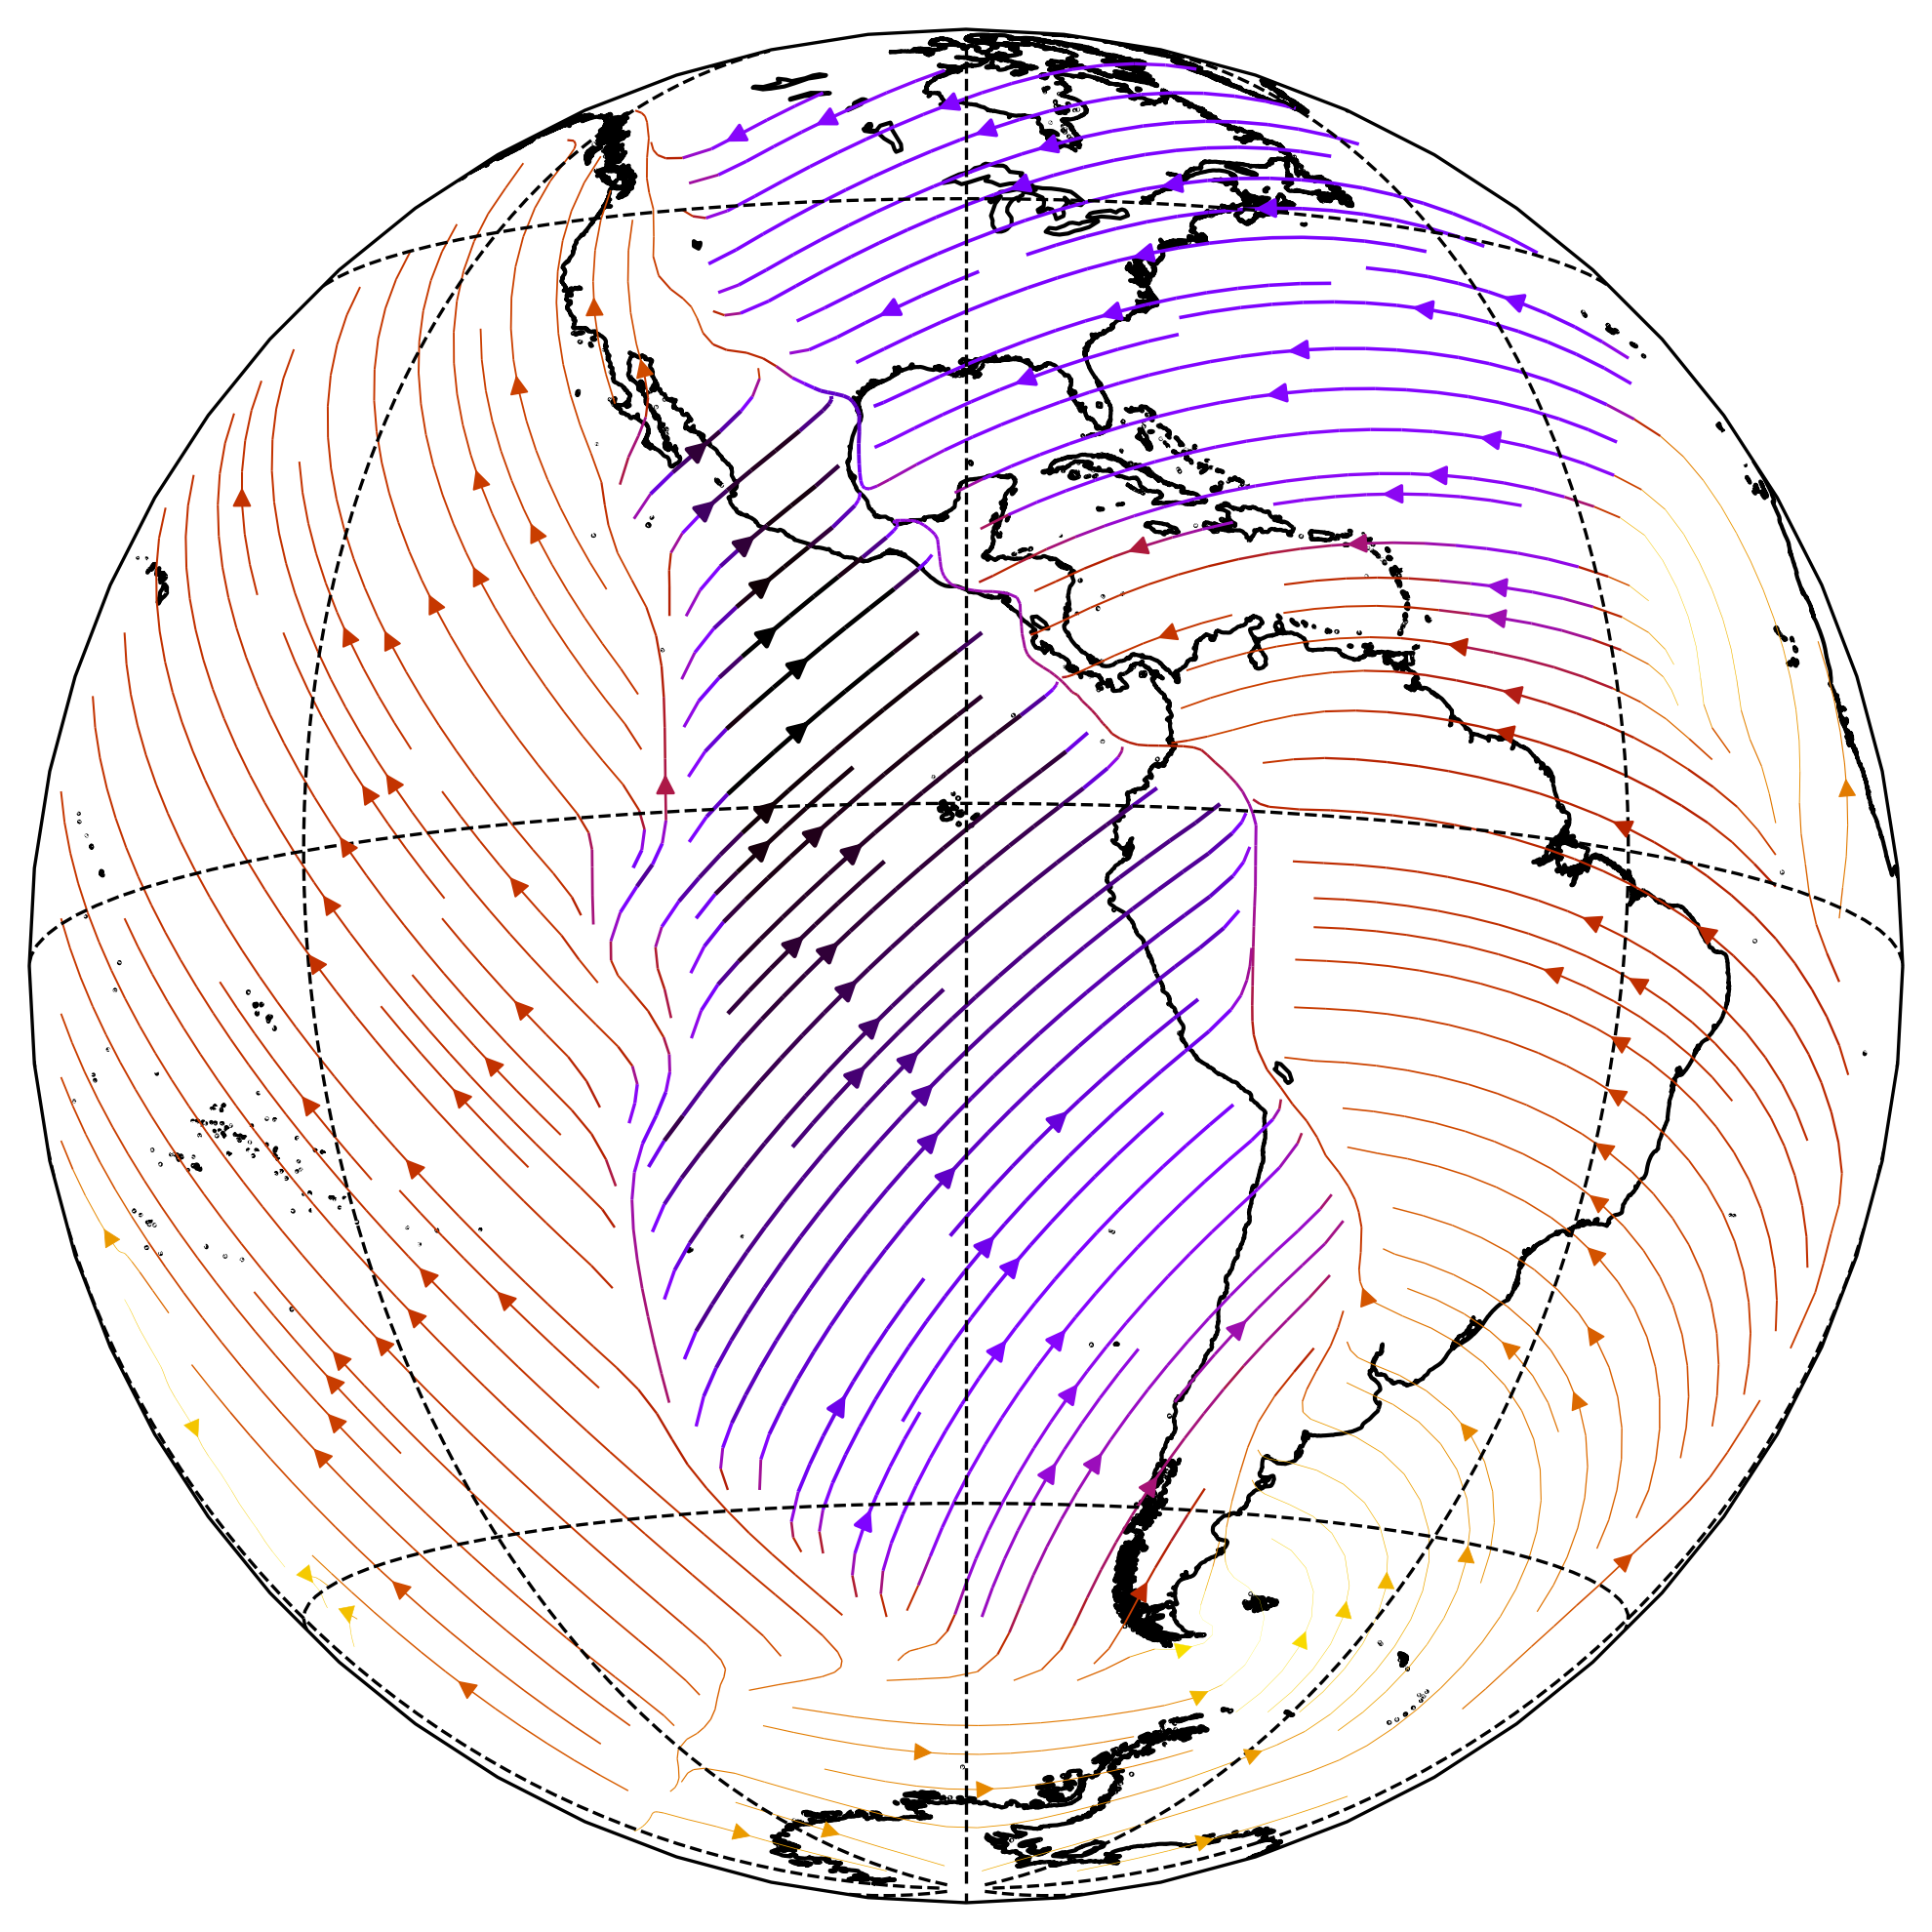

In [14]:
fig = plt.figure(figsize=(12,8),dpi=300)
pmap = fig.add_axes([0.1,0.1,0.8,0.8], projection = ccrs.Orthographic(central_longitude=-90, central_latitude=-10))

# Draw coastlines, parallels, meridians, and lake features
pmap.coastlines(resolution='10m', color='black', linewidth=1)
pmap.gridlines(color='black',linestyle='--', xlocs=np.arange(-180,180,45), ylocs=np.arange(-90,90,45))
pmap.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')

# Create X and Y nodes
lons, lats = np.meshgrid(Xnodes,Ynodes)
# Compute native x,y coordinates of grid.
x, y = lons, lats

# Create the streamplot
speed = np.sqrt(u**2 + v**2)
S = pmap.streamplot(Xnodes,Ynodes,u,v,color=speed, transform=ccrs.PlateCarree(), linewidth=0.02*speed, cmap=plt.cm.gnuplot_r, density=2)

plt.show()
